In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

# Underthesea - A Vietnamese NLP toolkit
!pip install underthesea > /dev/null 2>&1 # not print the pip installation
from underthesea import word_tokenize
from underthesea import text_normalize

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import wordcloud
import regex as re
import string
import random
import nltk
from datasets import load_dataset
from inspect import signature

# TensorFlow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# scikit-learn
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
dataset = load_dataset("uit-nlp/vietnamese_students_feedback") # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8573337

train_df = dataset['train'].to_pandas()
val_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

# Concatenate all DataFrames into one (so data is more objective and balance)
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Randomly mix/shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns = {'sentence': 'content', 'sentiment': 'label'}, inplace = True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset vietnamese_students_feedback downloaded and prepared to /root/.cache/huggingface/datasets/uit-nlp___vietnamese_students_feedback/default/1.0.0/b01aa0fea00f1179ef9c093babb5e91f44bc60f19ded600754a08e018503e40f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
print('Dataset columns, rows:', df.shape)
print('How many labels and their counts?:', df['label'].value_counts())
print('How many kind of topic and their counts?:', df['topic'].value_counts())

Dataset columns, rows: (16175, 3)
How many labels and their counts?: label
2    8038
0    7439
1     698
Name: count, dtype: int64
How many kind of topic and their counts?: topic
0    11607
1     3040
3      816
2      712
Name: count, dtype: int64


## Text Preprocessing

In [4]:
df = df.drop_duplicates("content") # drop duplicates
df = df.dropna() # drop null
print('How many label and their count left?:', df['label'].value_counts())

How many label and their count left?: label
2    8038
0    7438
1     698
Name: count, dtype: int64


In [5]:
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F"
                u"\U0001F300-\U0001F5FF" 
                u"\U0001F680-\U0001F6FF"  
                u"\U0001F1E0-\U0001F1FF"  
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE) # Unicode emojis. 

def clean_text(text):
    text = text.lower() # lowercase text
    
    text = re.sub(emoji_pattern, " ", text) # remove emojis
    
    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')
    
    # Ensure space before and after any punctuation mark
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)
    
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+",r"\1", text) # reduce consecutive punctuation
    
    # Remove any leading or trailing spaces, or leading or trailing punctuation marks from the text
    text = text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]
        
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuation
        
    text = re.sub(r"\s+", " ", text) # reduce multiple spaces
    
    text = text_normalize(text) # make sure punctunation is in the right letter (Vietnamese case)
    text = word_tokenize(text, format="text") # tokenize the cleaned text
    # text = unidecode(text) # remove accent marks from sentences (no significant difference when accent marks is removed or kept)
    
    '''
    Proper tokenization allows models or algorithms to understand the semantics of the text better. 
    For instance, `"đi chơi" (go play)` should be treated as one unit 
    instead of two separate words "đi" (go) and "chơi" (play) for proper semantic understanding.
    '''
    return text

In [6]:
df['corpus'] = df['content'].map(lambda text: clean_text(text))                                                     
# Final check
df.head(20)

,content,label,topic,corpus
0,khiến sinh viên bị thụ động .,0,3,khiến sinh_viên bị thụ_động
1,"thầy ơi , giảng bài cho tụi em đi !",0,0,thầy ơi giảng bài cho tụi em đi
2,"sinh viên hỏi , nhận câu trả lời cũng như khôn...",0,0,sinh_viên hỏi nhận câu trả_lời cũng như không hỏi
3,giáo viên dạy hay .,2,0,giáo_viên dạy hay
4,"cô dạy nhanh lắm , chúng em không theo kịp .",0,0,cô dạy nhanh lắm chúng_em không theo kịp
5,giảng viên rất có tâm huyết .,2,0,giảng_viên rất có tâm_huyết
6,"cô biết cách truyền cảm hứng cho sinh viên , t...",2,0,cô biết cách truyền cảm_hứng cho sinh_viên tận...
7,thời gian lên lớp hợp lý .,2,0,thời_gian lên lớp hợp_lý
8,em xin có ý kiến doubledot giảng viên lý thuyế...,0,0,em xin có ý_kiến doubledot giảng_viên lý_thuyế...
9,dạy chậm hơn tiết thực hành .,0,0,dạy chậm hơn tiết thực_hành


## Exploratory Data Analysis

Number of words: 16001
Most common words: [('thầy dạy hay dễ hiểu', 4), ('em cảm_ơn', 3), ('nhiệt_tình tâm_huyết', 3), ('nhiệt_tình vui_tính', 3), ('giảng_viên tận_tâm nhiệt_tình', 3), ('giảng_viên dạy nhiệt_tình dễ hiểu', 3), ('giảng_viên nhiệt_tình tận_tâm', 3), ('thầy dạy nhiệt_tình tận_tâm', 3), ('giáo_viên dạy hay', 2), ('thầy giảng bài kỹ', 2), ('giáo_viên nhiệt_tình vui_vẻ', 2), ('vui tính hòa đồng với sinh_viên', 2), ('thầy nhiệt_tình tận_tâm', 2), ('thầy vui tính giảng_bài dễ hiểu', 2), ('tuyệt', 2)]


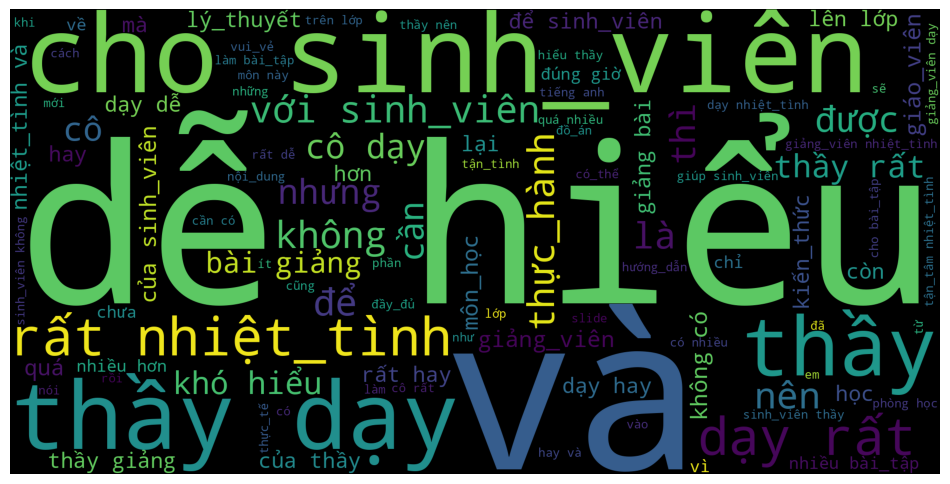

In [7]:
# Create bag-of-words
all_words = [token for token in df['corpus'].tolist() if token and token != '']

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# Print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

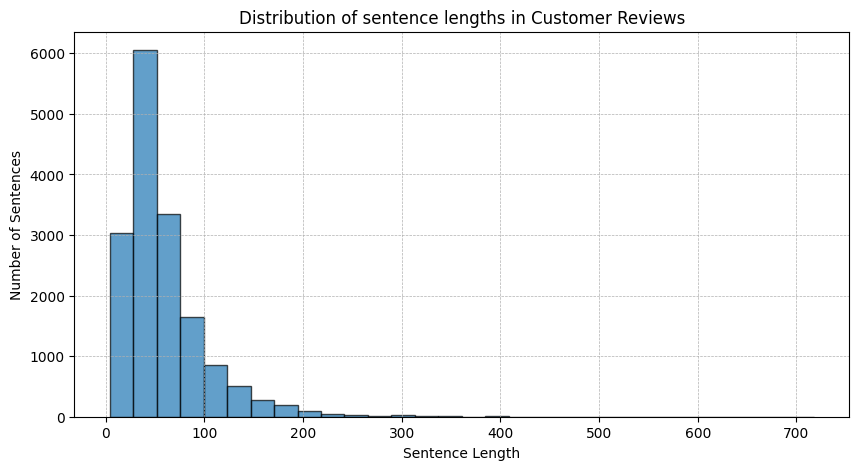

In [8]:
# Calculate the length of each sentence directly
lengths = df['content'].apply(len)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(lengths, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of sentence lengths in Customer Reviews')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

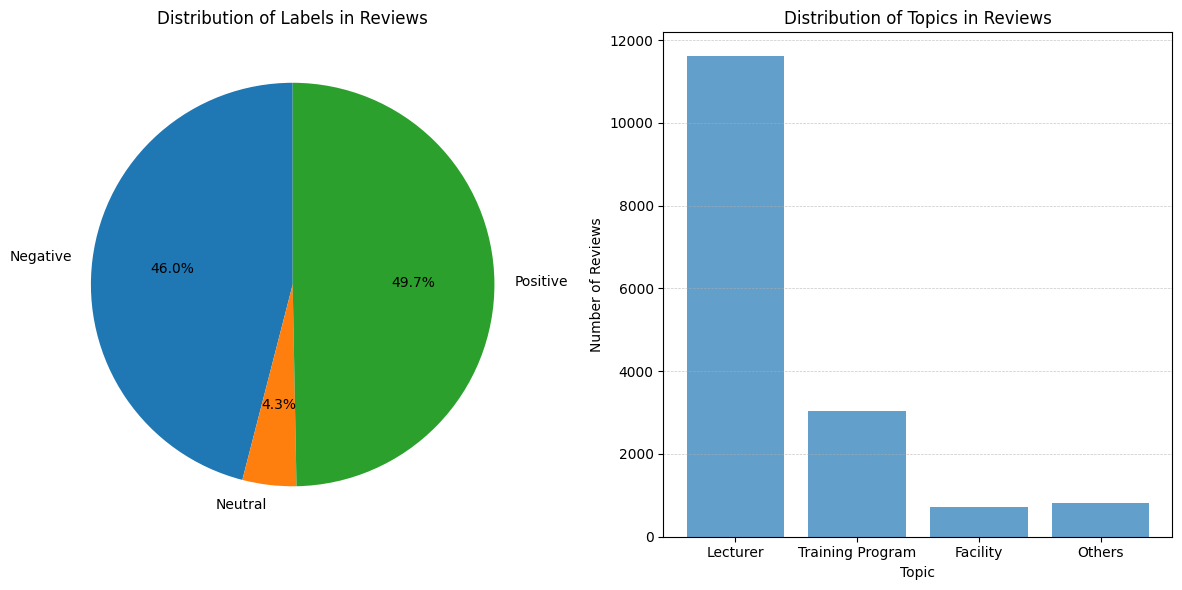

In [9]:
# Count the occurrences of each label and topic
label_counts = df['label'].value_counts().sort_index()
topic_counts = df['topic'].value_counts().sort_index()

# Set up the figure and axis
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for labels
labels = ['Negative', 'Neutral', 'Positive']  # updated labels
ax[0].pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Distribution of Labels in Reviews')

# Bar chart for topics
topics = ['Lecturer', 'Training Program', 'Facility', 'Others']  # updated topics
ax[1].bar(topics, topic_counts, alpha=0.7)
ax[1].set_title('Distribution of Topics in Reviews')
ax[1].set_xlabel('Topic')
ax[1].set_ylabel('Number of Reviews')
ax[1].grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
# First, split the data into 80% training and 20% temporary testing.
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    df['corpus'], 
    df['label'], 
    test_size=0.1, 
    stratify=df['topic'],
    random_state=42
)

## Over-sampling

In [11]:
from sklearn.utils import resample

# Separate neutral comments
neutral_indices = np.where(train_labels == 1)[0]
oversample_size = len(train_labels[train_labels == 0]) - len(neutral_indices)

# Over-sample the neutral comments
oversampled_neutral_indices = resample(neutral_indices,
                                       replace=True,
                                       n_samples=oversample_size)

# Combine the original sentences and labels with the oversampled data
oversampled_neutral_sentences = np.array(train_sentences)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([train_sentences, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = np.concatenate([train_labels, np.array([1] * oversample_size)], axis=0)


In [12]:
oversampled_neutral_sentences = np.array(train_sentences)[oversampled_neutral_indices]

train_sentences_oversampled = np.concatenate([train_sentences, oversampled_neutral_sentences], axis=0)
train_labels_oversampled = pd.Series(train_labels_oversampled)

In [13]:
# Count occurrences of each label in train_labels_oversampled
unique_labels, counts = np.unique(train_labels_oversampled, return_counts=True)

# Display the distribution
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

Label 0: 6674
Label 1: 6674
Label 2: 7264


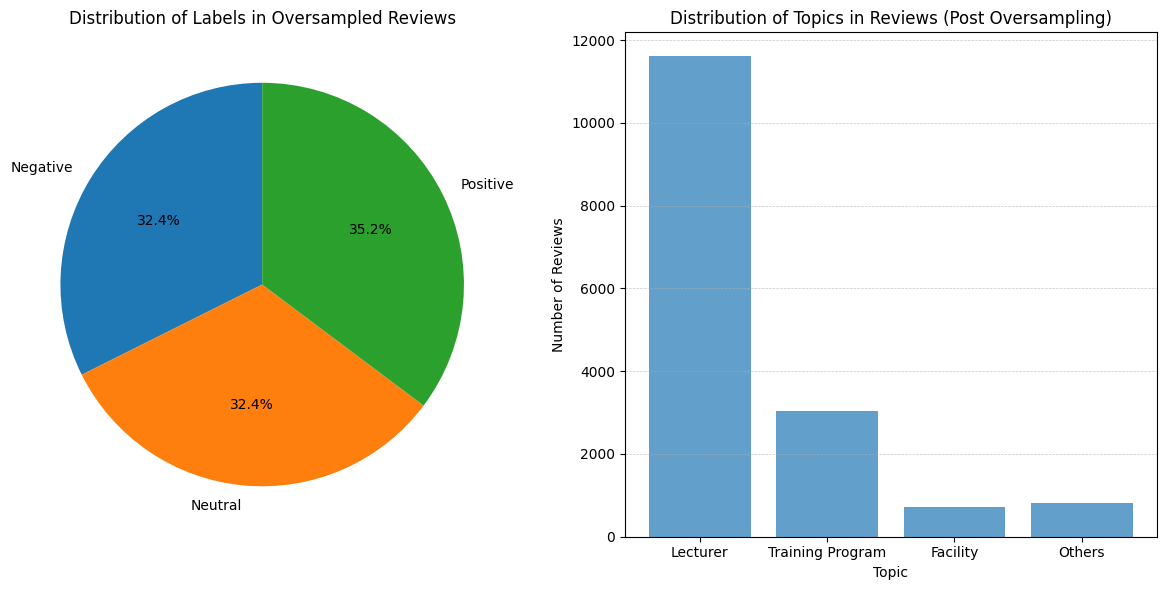

In [14]:
# First, you need to create a new DataFrame or series for your oversampled data
# For this example, let's assume your oversampled DataFrame is `df_oversampled`

# Update the label counts based on the oversampled data
label_counts_oversampled = pd.Series(train_labels_oversampled).value_counts().sort_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for labels after over-sampling
labels = ['Negative', 'Neutral', 'Positive']  
ax[0].pie(label_counts_oversampled, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Distribution of Labels in Oversampled Reviews')

# Bar chart for topics (assuming they were oversampled too)
topics = ['Lecturer', 'Training Program', 'Facility', 'Others']
ax[1].bar(topics, topic_counts, alpha=0.7)
ax[1].set_title('Distribution of Topics in Reviews (Post Oversampling)')
ax[1].set_xlabel('Topic')
ax[1].set_ylabel('Number of Reviews')
ax[1].grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

## Bag of Words

In [15]:

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data only
vectorizer.fit(train_sentences)

CountVectorizer()

In [16]:
sample_sentences = df['corpus'].head(5).tolist() # select a sample of sentences
sample_transformed = vectorizer.transform(sample_sentences) # transform the sample sentences

sample_array = sample_transformed.toarray() # convert the transformed data

# Print results for each sentence in the sample
for idx, sentence in enumerate(sample_sentences):
    print(f"Sentence: {sentence}")
    print("Token : Count")
    for token, count in zip(vectorizer.get_feature_names_out(), sample_array[idx]):
        if count > 0:
            print(f"{token} : {count}")
    print("------\n")

Sentence: khiến sinh_viên bị thụ_động
Token : Count
bị : 1
khiến : 1
sinh_viên : 1
thụ_động : 1
------

Sentence: thầy ơi giảng bài cho tụi em đi
Token : Count
bài : 1
cho : 1
em : 1
giảng : 1
thầy : 1
tụi : 1
đi : 1
ơi : 1
------

Sentence: sinh_viên hỏi nhận câu trả_lời cũng như không hỏi
Token : Count
câu : 1
cũng : 1
hỏi : 2
không : 1
như : 1
nhận : 1
sinh_viên : 1
trả_lời : 1
------

Sentence: giáo_viên dạy hay
Token : Count
dạy : 1
giáo_viên : 1
hay : 1
------

Sentence: cô dạy nhanh lắm chúng_em không theo kịp
Token : Count
chúng_em : 1
cô : 1
dạy : 1
không : 1
kịp : 1
lắm : 1
nhanh : 1
theo : 1
------



In [17]:
# Convert the entire oversampled sentences into the Bag-of-Words representation
X_oversampled_bow = vectorizer.transform(train_sentences_oversampled)
y_oversampled_bow = train_labels_oversampled

+ Text vectorization converts raw text into integer sequences, without capturing semantic meaning. 

+ Embeddings, on the other hand, transform these integers into dense vectors that capture semantic relationships between words. 

+ `Using separate embeddings for different models allows each model to learn task-specific semantic representations`. This can improve model performance as the embedding space becomes tailored to each task's nuances.

## Text Vectorization

In [18]:
MAX_VOCAB_LENGTH = 20000

sequence_lengths = [len(sentence.split()) for sentence in train_sentences] # Calculate the length of each sentence in the training data
MAX_LENGTH = int(np.percentile(sequence_lengths, 95)) # Set MAX_LENGTH as the 95th percentile of the sequence lengths

In [19]:
text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB_LENGTH, # Maximum size of the vocabulary for this layer
                                    standardize="lower_and_strip_punctuation", # Text will be lowercased and all punctuation removed
                                    split="whitespace", # Split on whitespace
                                    ngrams=None, 
                                    output_mode="int", # Outputs integer indices, one integer index per split string token
                                    output_sequence_length=MAX_LENGTH) # the output will have its time dimension padded or truncated to exactly output_sequence_length values

text_vectorizer.adapt(train_sentences) # Computes a vocabulary of string terms from tokens in a dataset.

In [20]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # ([UNK] token is unknown words)
bottom_5_words = words_in_vocab[-5:] 
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 4543
Top 5 most common words: ['', '[UNK]', 'thầy', 'sinhviên', 'dạy']
Bottom 5 least common words: ['2000', '200', '1983', '19', '140']


## Embedding

In [21]:
def create_embedding_layer(input_dim=MAX_VOCAB_LENGTH, output_dim=128, embeddings_initializer="uniform", input_length=MAX_LENGTH, name=None):
    """
    Create an Embedding layer for use in a deep learning model.

    Parameters:
    - input_dim (int): Size of the input vocabulary.
    - output_dim (int, optional): Dimension of the dense embedding. Defaults to 128.
    - embeddings_initializer (str or keras.initializers, optional): Initializer for the embeddings matrix. Defaults to "uniform".
    - input_length (int, optional): Length of input sequences, when it is constant.
    - name (str, optional): Name of the layer. Defaults to None.

    Returns:
    - TensorFlow/Keras Embedding layer.
    """
    return layers.Embedding(
        input_dim=input_dim,
        output_dim=output_dim,
        embeddings_initializer=embeddings_initializer,
        input_length=input_length,
        name=name
    )

## Machine Learning Models

#### Optimized Functions for ML Training

In [22]:
def create_ml_model(model_type, **kwargs):
    '''
    Create Machine Learning model
    '''
    models = {
        'naive_bayes': MultinomialNB,
        'svm': LinearSVC,
        'random_forest': RandomForestClassifier,
        'logistic_regression': LogisticRegression,
        'ml_ensemble': lambda: create_ml_stacking_classifier(**kwargs)
    }
    
    # Retrieve the model class based on the model_type argument
    model = models.get(model_type.lower())
    
    # Check if the model type exists
    if model:
        return model(**kwargs)
    else:
        supported_models = ", ".join(models.keys())
        print(f"Error: Model type '{model_type}' is not supported.\n"
              f"Supported models are: {supported_models}.\n"
              f"Please add your perferred model to create_model function.")
        return None

In [23]:
def kfold_evaluation(model, X, y, kfold):
    '''
    1. Train ML model on KFold
    
    2. Return metrics for each KFold and all KFolds
    '''
    fold_results = [] # average validation data results on all Kfolds
    fold_result_each_kfold = [] # training and validation results on each Kfold

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on both sets
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)
        
        # Calculate metrics for both sets
        train_metrics = calculate_results(y_train, train_predictions)
        val_metrics = calculate_results(y_val, val_predictions)

        fold_result = {
            'fold': len(fold_results) + 1,
            'train_metrics': train_metrics,
            'validation_metrics': val_metrics
        }

        fold_results.append(val_metrics)
        fold_result_each_kfold.append(fold_result)

    # Compute the average metrics over all folds
    model_results = {
        "accuracy": np.mean([result["accuracy"] for result in fold_results]),
        "precision": np.mean([result["precision"] for result in fold_results]),
        "recall": np.mean([result["recall"] for result in fold_results]),
        "f1": np.mean([result["f1"] for result in fold_results])
    }

    # Retrain the model on the entire dataset
    model.fit(X, y)

    return model, fold_result_each_kfold, model_results

In [24]:
def calculate_results(y_true, y_pred):
    '''
    Calculate accuracy, precision, recall, f1 score for a model
    '''
    model_accuracy = accuracy_score(y_true, y_pred) * 100  # Scale to 1-100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    
    return model_results

In [25]:
def compare_baseline_to_new_results(baseline_results, new_model_results, baseline_name='Baseline', new_model_name='New Model'):
    '''
    Compare baseline and new model results on metrics and plot the results using a line graph.
    '''
    metrics = list(baseline_results.keys())
    baseline_scores = [baseline_results[metric] * 100 if metric != 'accuracy' else baseline_results[metric] for metric in metrics]
    new_model_scores = [new_model_results[metric] * 100 if metric != 'accuracy' else new_model_results[metric] for metric in metrics]

    # Textual comparison
    # for key, value in baseline_results.items():
        # print(f"{baseline_name} {key}: {value:.2f}, {new_model_name} {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

    # Set up the seaborn style and palette
    sns.set(style="whitegrid", palette="muted")
    colors = ["#3498db", "#e74c3c"]  # Blue for baseline, Red for new model

    # Plotting
    x = np.arange(len(metrics))
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x, baseline_scores, label=baseline_name, marker='o', markersize=6, linewidth=2, color=colors[0])
    ax.plot(x, new_model_scores, label=new_model_name, marker='s', markersize=6, linewidth=2, color=colors[1])
    
    # Adjust y-axis range
    max_score = max(max(baseline_scores), max(new_model_scores))
    min_score = min(min(baseline_scores), min(new_model_scores))
    ax.set_ylim([min_score - 1, max_score + 1])  # Add padding to the top and bottom
    ax.set_facecolor('#f8f9fa')  # Light gray background

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores (%)')
    ax.set_title(f'Performance Comparison: {baseline_name} vs {new_model_name}')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Attach a text label at each marker, displaying its height with increased vertical offset
    label_offset = 0.25  # Increased vertical offset for the labels
    for i in range(len(metrics)):
        ax.text(x[i], baseline_scores[i] + label_offset, f'{baseline_scores[i]:.2f}%', ha='center', va='bottom')
        ax.text(x[i], new_model_scores[i] + label_offset, f'{new_model_scores[i]:.2f}%', ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

In [26]:
def format_metrics_compact(metrics):
    '''
    Helper function to format metrics compactly
    '''
    return ", ".join([f"{key.capitalize()}: {value:.2f}" for key, value in metrics.items()])

def display_all_folds_results(model_name, model_results):
    '''
    Print average metrics of validation data on all KFolds
    '''
    print(f"Average {model_name} Performance Metrics Across All Folds (on validation data):")
    print(f"- Accuracy: {model_results['accuracy']:.2f}%")
    print(f"- Precision: {model_results['precision']:.4f}")
    print(f"- Recall: {model_results['recall']:.4f}")
    print(f"- F1 Score: {model_results['f1']:.4f}")

In [27]:
def display_each_fold_result(model_name, fold_results):
    '''
    Print metrics of training and validation data on each KFold and plot the accuracy graph using Seaborn.
    '''
    # Set up the seaborn style and palette
    sns.set(style="whitegrid", palette="muted")
    colors = ["#3498db", "#e74c3c"]  # Blue for Training, Red for Validation

    # Header
    print(f"{model_name} Performance Metrics Across Each Fold (on training and validation data):")
    print()
    print(f"{'Fold':<5} | {'Training Metrics':<70} | {'Validation Metrics':<70}")
    print("-" * 150)

    # Prepare data for plotting
    train_accuracies = []
    val_accuracies = []
    folds = []

    # Display results for each fold and collect data for graph
    for result in fold_results:
        train_metrics_formatted = format_metrics_compact(result['train_metrics'])
        val_metrics_formatted = format_metrics_compact(result['validation_metrics'])
        print(f"{result['fold']:<5} | {train_metrics_formatted:<70} | {val_metrics_formatted:<70}")

        # Append data for graph
        folds.append(result['fold'])
        train_accuracies.append(result['train_metrics']['accuracy'])
        val_accuracies.append(result['validation_metrics']['accuracy'])

    # Plotting the accuracies using Seaborn
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(x=folds, y=train_accuracies, label='Training Accuracy', marker='o', color=colors[0])
    sns.lineplot(x=folds, y=val_accuracies, label='Validation Accuracy', marker='o', color=colors[1])
    ax.set_facecolor('#f8f9fa')  # Light gray background

    # Adding percentages on markers
    label_offset = 0.25  # Increased vertical offset for the labels
    for i, (tr_acc, val_acc) in enumerate(zip(train_accuracies, val_accuracies)):
        ax.text(folds[i], tr_acc + label_offset, f"{tr_acc:.2f}%", ha='center', va='bottom')
        ax.text(folds[i], val_acc + label_offset, f"{val_acc:.2f}%", ha='center', va='bottom')

    plt.title(f"{model_name} model: Training vs Validation Accuracy per Fold")
    plt.xlabel('Fold')
    plt.ylabel('Accuracy (%)')
    plt.xticks(folds)
    plt.legend()
    ax.margins(y=0.2)  # Add 10% padding to the top and bottom
    fig.tight_layout()
    plt.show()

In [28]:
from sklearn.model_selection import StratifiedKFold

# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

### Model 0: Logistic Regression (Base Model)

In [29]:
lr_model = create_ml_model('logistic_regression', max_iter=5000, solver='saga', multi_class='multinomial') # Set for multi-class classification

In [30]:
lr_model, lr_each_fold_results, lr_results = kfold_evaluation(lr_model, X_oversampled_bow, y_oversampled_bow, skf)

In [31]:
display_all_folds_results("Logistic Regression", lr_results)

Average Logistic Regression Performance Metrics Across All Folds (on validation data):
- Accuracy: 89.57%
- Precision: 0.8983
- Recall: 0.8957
- F1 Score: 0.8955


Logistic Regression Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 93.76, Precision: 0.94, Recall: 0.94, F1: 0.94               | Accuracy: 89.86, Precision: 0.90, Recall: 0.90, F1: 0.90              
2     | Accuracy: 93.42, Precision: 0.94, Recall: 0.93, F1: 0.93               | Accuracy: 89.86, Precision: 0.90, Recall: 0.90, F1: 0.90              
3     | Accuracy: 93.58, Precision: 0.94, Recall: 0.94, F1: 0.94               | Accuracy: 89.25, Precision: 0.90, Recall: 0.89, F1: 0.89              
4     | Accuracy: 93.62, Precision: 0.94, Recall: 0.94, F1: 0.94               | Accuracy: 89.37, Precision: 0.90, Recall: 0.89, F1: 0.89           

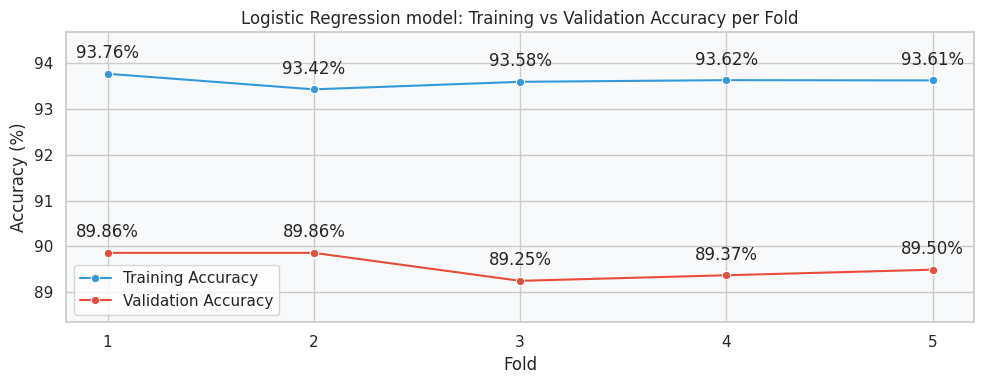

In [32]:
display_each_fold_result("Logistic Regression",lr_each_fold_results)

### Model 1: Support Vector Machines (SVM)

In [33]:
svm_model= create_ml_model('svm', max_iter=5000)

In [34]:
svm_model, svm_each_fold_results, svm_results = kfold_evaluation(svm_model, X_oversampled_bow, y_oversampled_bow, skf)

In [35]:
display_all_folds_results("SVM", svm_results)

Average SVM Performance Metrics Across All Folds (on validation data):
- Accuracy: 90.24%
- Precision: 0.9043
- Recall: 0.9024
- F1 Score: 0.9020


SVM Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 95.77, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 89.98, Precision: 0.90, Recall: 0.90, F1: 0.90              
2     | Accuracy: 95.54, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.61, Precision: 0.91, Recall: 0.91, F1: 0.91              
3     | Accuracy: 95.52, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.05, Precision: 0.90, Recall: 0.90, F1: 0.90              
4     | Accuracy: 95.68, Precision: 0.96, Recall: 0.96, F1: 0.96               | Accuracy: 90.20, Precision: 0.90, Recall: 0.90, F1: 0.90              
5     | Accu

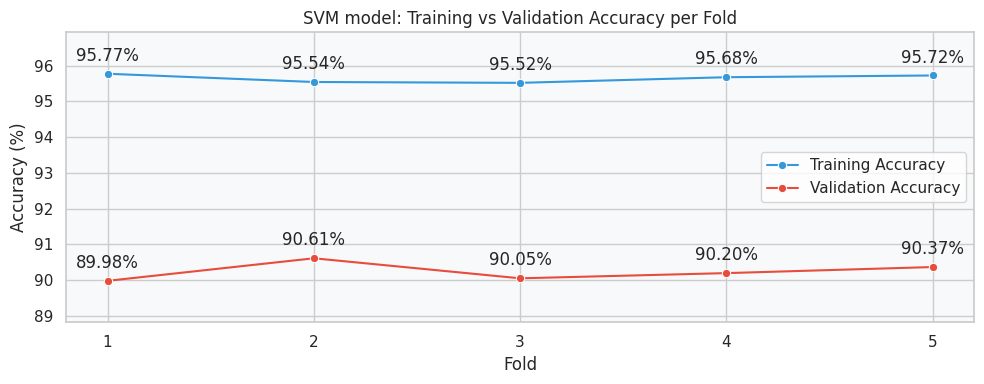

In [36]:
display_each_fold_result("SVM",svm_each_fold_results)

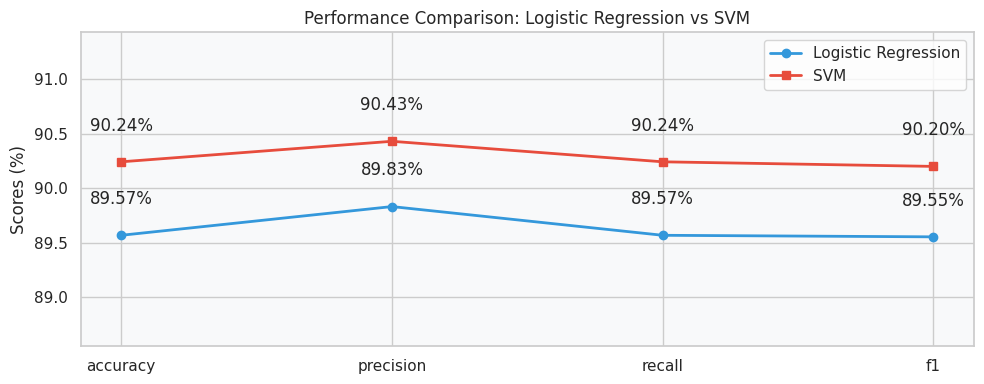

In [37]:
# Compare Model 1: Support Vector Machines model with Model 0: Logistic Regression
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=svm_results,
                                baseline_name='Logistic Regression', new_model_name='SVM')

### Model 2: Random Forest

In [38]:
rf_model= create_ml_model('random_forest', n_estimators=100)

In [39]:
rf_model, rf_each_fold_results, rf_results = kfold_evaluation(rf_model, X_oversampled_bow, y_oversampled_bow, skf)

In [40]:
display_all_folds_results("Random Forest", rf_results)

Average Random Forest Performance Metrics Across All Folds (on validation data):
- Accuracy: 93.65%
- Precision: 0.9367
- Recall: 0.9365
- F1 Score: 0.9360


Random Forest Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 99.98, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 94.18, Precision: 0.94, Recall: 0.94, F1: 0.94              
2     | Accuracy: 99.98, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 92.97, Precision: 0.93, Recall: 0.93, F1: 0.93              
3     | Accuracy: 99.99, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 93.67, Precision: 0.94, Recall: 0.94, F1: 0.94              
4     | Accuracy: 99.98, Precision: 1.00, Recall: 1.00, F1: 1.00               | Accuracy: 93.67, Precision: 0.94, Recall: 0.94, F1: 0.94              
5 

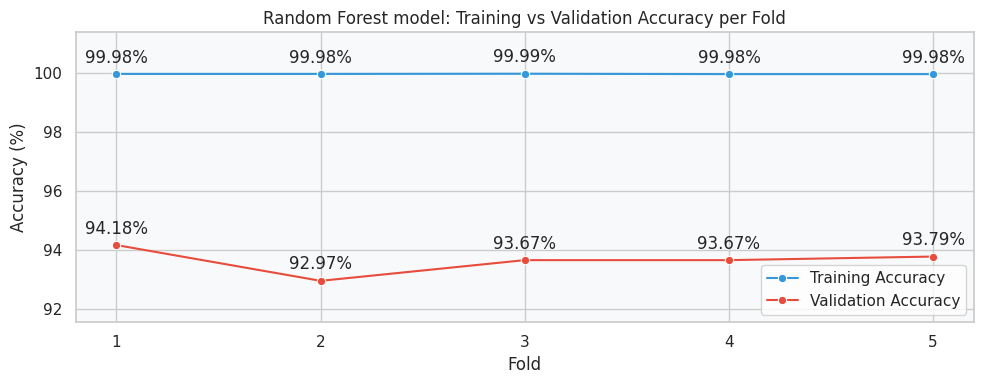

In [41]:
display_each_fold_result("Random Forest",rf_each_fold_results)

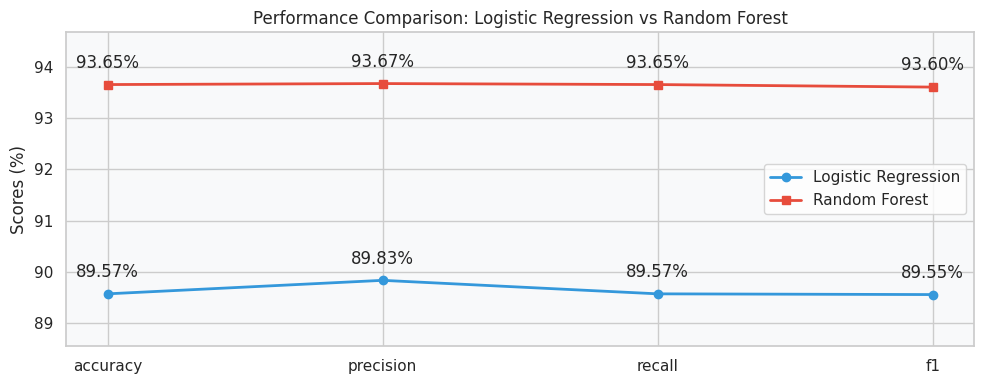

In [42]:
# Compare Model 2: Random Forest model with Model 0: Logistic Regression
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=rf_results,
                                baseline_name='Logistic Regression', new_model_name='Random Forest')

### Model 3: Stacking SVM, Random Forest, Logistic Regression model

In [43]:
def create_ml_stacking_classifier(**kwargs):
    svm_model = make_pipeline(MaxAbsScaler(), LinearSVC(max_iter=10000))
    rf_model = RandomForestClassifier(n_estimators=100)
    lr_model = LogisticRegression(max_iter=10000, solver='saga', multi_class='multinomial')

    estimators = kwargs.get('estimators', [
        ('svm', svm_model),
        # ('rf', rf_model),
        ('lr', lr_model)
    ])
    final_estimator = kwargs.get('final_estimators', LogisticRegression(max_iter=10000, solver='saga'))
    
    return StackingClassifier(estimators, final_estimator)

In [44]:
ml_ensemble_model = create_ml_model('ml_ensemble')

In [45]:
ml_ensemble_model, ml_ensemble_each_fold_results, ml_ensemble_results = kfold_evaluation(ml_ensemble_model, X_oversampled_bow, y_oversampled_bow, skf)

In [46]:
display_all_folds_results("Machine Learning Ensemble", ml_ensemble_results)

Average Machine Learning Ensemble Performance Metrics Across All Folds (on validation data):
- Accuracy: 90.22%
- Precision: 0.9033
- Recall: 0.9022
- F1 Score: 0.9021


Machine Learning Ensemble Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 94.95, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.01, Precision: 0.90, Recall: 0.90, F1: 0.90              
2     | Accuracy: 94.97, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.25, Precision: 0.90, Recall: 0.90, F1: 0.90              
3     | Accuracy: 94.83, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.27, Precision: 0.90, Recall: 0.90, F1: 0.90              
4     | Accuracy: 94.68, Precision: 0.95, Recall: 0.95, F1: 0.95               | Accuracy: 90.00, Precision: 0.90, Recall: 0.90, F1: 0.90     

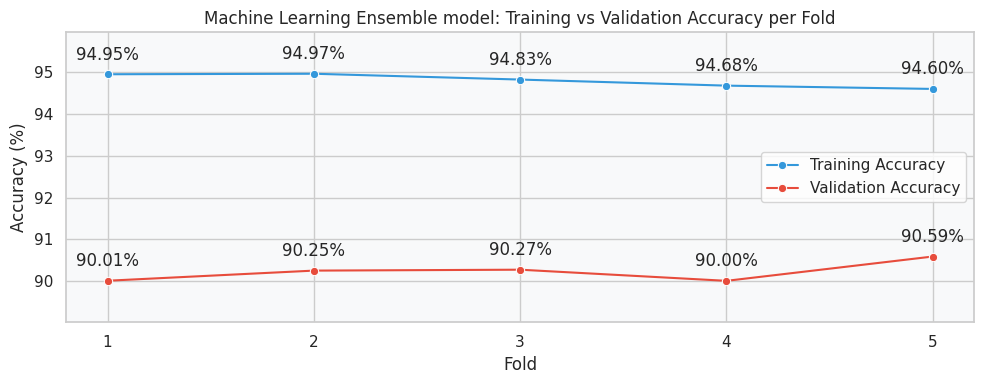

In [47]:
display_each_fold_result("Machine Learning Ensemble", ml_ensemble_each_fold_results)

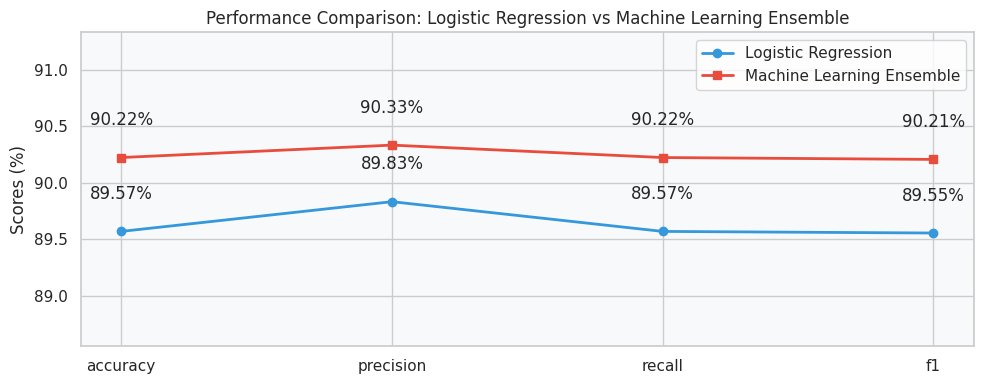

In [48]:
# Compare Model 3: Machine Learning Emsemble model with Model 0: Logistic Regression model
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=ml_ensemble_results,
                                baseline_name='Logistic Regression', new_model_name='Machine Learning Ensemble')

## Deep Learning Models

#### Optimized Parameters for DL training

In [49]:
# Default parameters
CV = ShuffleSplit(n_splits=2, test_size=0.1, random_state=42) 
EPOCHS = 5
BATCH_SIZE = 32

In [50]:
# Parameters for RandomizedSearchCV
param_dist = {
    'learning_rate': [0.01, 0.001, 0.0001],
    'dense_units': [32, 64, 128],
    'dropout': [0.2, 0.3, 0.4, 0.5],
    'l1_reg': [0.001, 0.01, 0.1],
    'l2_reg': [0.001, 0.01, 0.1],
    'batch_normalization': [True, False],
    
    # options for convolutional layers
    'kernel_initializer': ["he_uniform", 'he_normal'],
    'padding': ['valid', 'same'],  
}

In [51]:
# Split the data into training and validation sets (for deep learning model)
X_train, X_val, y_train, y_val = train_test_split(
    train_sentences_oversampled, 
    train_labels_oversampled, 
    test_size=0.1,  # 10% of the data will be used for validation
    random_state=42
)

#### Optimized Functions for DL training

In [52]:
def filter_param_dist_for_model(model_creation_fn, param_dist=param_dist):
    """
    Filter the parameter distribution dictionary to only include keys that are 
    valid parameters for the given model creation function.

    Parameters:
    - param_dist: Original full parameter distribution dictionary.
    - model_creation_fn: Function used to create the model.

    Returns:
    - Filtered parameter distribution dictionary.
    """
    # Inspect the signature of the model creation function
    valid_params = signature(model_creation_fn).parameters.keys()

    # Filter the param_dist dictionary
    filtered_param_dist = {key: value for key, value in param_dist.items() if key in valid_params}
    
    return filtered_param_dist

In [53]:
def perform_random_search(model_creation_fn, model_name, param_dist=param_dist, X_train=X_train, y_train=y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, n_iter=3, cv=skf):
    """
    Perform Randomized Search for hyperparameter tuning on a deep learning model.
    """
    
    # Define the parameter distribution including epochs and batch_size, 
    param_dist = {
        'epochs': [3, 5],
        'batch_size': [16, 32, 64],
        **(filter_param_dist_for_model(model_creation_fn)) # output is param_dist that have only keys that model_creation_fn has
    }
    
    # Wrap the model creation function with KerasClassifier
    keras_model = KerasClassifier(build_fn=model_creation_fn, epochs=epochs, batch_size=batch_size, verbose=0)

    # Set up RandomizedSearchCV
    randomized_search = RandomizedSearchCV(estimator=keras_model, param_distributions=param_dist, n_iter=n_iter, cv=cv, verbose=0)

    # Fit the RandomizedSearchCV to find the best parameters
    randomized_search.fit(X_train, y_train)

    # Display results
    print(f"\n{model_name} Model Results After Hyperparameter Tuning:\n")
    
    # Get all the results from the randomized search
    cv_results = randomized_search.cv_results_
    for params, mean_test_score, rank in zip(cv_results["params"], cv_results["mean_test_score"], cv_results["rank_test_score"]):
        print(f"Params: {params} - Mean Test Score: {mean_test_score:.2f} - Rank: {rank}")

    # Get the best parameters
    best_parameters = randomized_search.best_params_
    print(f"\nBest Parameters from {model_name} model: {best_parameters}\n")

    # Retrieve the best model after search
    best_model = randomized_search.best_estimator_.model

    return best_model

In [54]:
def display_dl_results(best_model, model_name, X_val=X_val, y_val=y_val):
    """
    Display results of a deep learning model after hyperparameter tuning and evaluate on validation data.
    """
    # Display the best model's summary
    best_model.summary()

    # Predict on the validation set using the best model
    pred_probs = best_model.predict(X_val, verbose=0)
    class_preds = np.argmax(pred_probs, axis=1)

    # Calculate and display results (accuracy, precision, recall, and f1 score)
    results = calculate_results(y_true=y_val, y_pred=class_preds)
    print(f"\n{model_name} Validation Data Results:")
    for metric, score in results.items():
        print(f"- {metric.capitalize()}: {score:.2f}")
        
    return results

`RandomizedSearchCV` efficiently explores the hyperparameter space by randomly sampling a subset of parameter combinations and assessing their performance. When used together, they provide a robust and efficient method for hyperparameter tuning, ensuring that the model's performance is well-validated across multiple folds of the dataset.

### Model 1: Fully Connected Layers Model

***Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)***


In [55]:
def create_fc_model(learning_rate=0.001, dense_units=32, dropout=0.5, l2_reg=0.01, activation='relu'):
    inputs = layers.Input(shape=(1, ), dtype="string")
    x = text_vectorizer(inputs)
    x = create_embedding_layer(name='base_dense_embedding')(x)

    # Flatten the embeddings
    x = layers.Flatten()(x)

    # Add fully connected (Dense) layers with dropout
    x = layers.Dense(dense_units*2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(3, activation="softmax")(x)
    
    model = Model(inputs, outputs, name="fully_connected_layers_model")
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    return model

In [56]:
fc_model = perform_random_search(create_fc_model, model_name='Fully Connected Layers')


Fully Connected Layers Model Results After Hyperparameter Tuning:

Params: {'learning_rate': 0.001, 'l2_reg': 0.01, 'epochs': 5, 'dropout': 0.2, 'dense_units': 32, 'batch_size': 64} - Mean Test Score: 0.92 - Rank: 1
Params: {'learning_rate': 0.01, 'l2_reg': 0.1, 'epochs': 5, 'dropout': 0.2, 'dense_units': 32, 'batch_size': 16} - Mean Test Score: 0.82 - Rank: 2
Params: {'learning_rate': 0.0001, 'l2_reg': 0.1, 'epochs': 3, 'dropout': 0.4, 'dense_units': 64, 'batch_size': 16} - Mean Test Score: 0.62 - Rank: 3

Best Parameters from Fully Connected Layers model: {'learning_rate': 0.001, 'l2_reg': 0.01, 'epochs': 5, 'dropout': 0.2, 'dense_units': 32, 'batch_size': 64}



In [57]:
fc_model_results = display_dl_results(fc_model, model_name='Fully Connected Layers')

Model: "fully_connected_layers_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 base_dense_embedding (Embed  (None, 24, 128)          2560000   
 ding)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 3072)              0         
                                                                 
 dense_45 (Dense)            (None, 64)                196672    
                                                                 
 dropout_30 (Dropout)        (None, 64

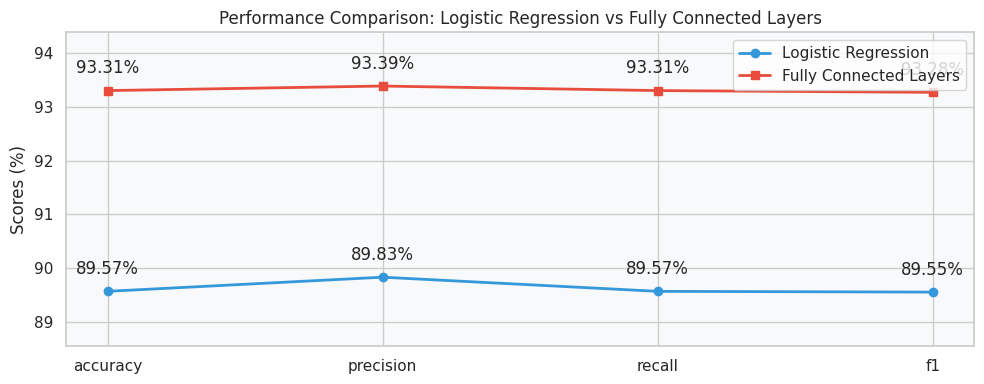

In [58]:
# Compare Model 1: Fully Connected Layer model with Model 0: Logistic Regression model
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=fc_model_results,
                                baseline_name='Logistic Regression', new_model_name='Fully Connected Layers')

## Dimensionality Reduction and Clustering

In [59]:
def extract_embeddings(model, sentences):
    """
    Uses the provided model to extract embeddings for the given sentences.
    Assumes that the embedding layer is named "embedding_1".
    """
    # Predict using the given model to get the output before the final dense layer
    intermediate_output = model.predict(sentences)

    return intermediate_output

test_embeddings = extract_embeddings(create_fc_model(), test_sentences)

51/51 [==============================] - 0s 3ms/step


In [60]:
len(test_embeddings[test_labels == 2]), len(test_embeddings[test_labels == 1]), len(test_embeddings[test_labels == 0])

(774, 80, 764)

In [61]:
positive_embeddings = test_embeddings[test_labels == 2][:50]
neutral_embeddings = test_embeddings[test_labels == 1][:50]
negative_embeddings = test_embeddings[test_labels == 0][:50]

positive_labels = np.array([2]*50)
neutral_labels = np.array([1]*50)
negative_labels = np.array([0]*50)

sampled_embeddings = np.concatenate([positive_embeddings, neutral_embeddings, negative_embeddings])
sampled_labels = np.concatenate([positive_labels, neutral_labels, negative_labels])

In [62]:
'''
The PCA algorithm expects a 2D array, but sampled_embeddings is a 3D array. 
The shape of sampled_embeddings is (num_samples, sequence_length, embedding_dimension).

To resolve this, average (or max-pool, etc.) over the sequence length to get a 2D shape: (num_samples, embedding_dimension).

(sequence_length = MAX_LENGTH; embedding_dim = output_dim)
'''
sampled_embeddings.shape 

if len(sampled_embeddings.shape) == 3:
    sampled_embeddings = np.mean(sampled_embeddings, axis=1)

In [63]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(sampled_embeddings)

kmeans = KMeans(n_clusters=3, n_init=10)
clustered_labels = kmeans.fit_predict(pca_result)

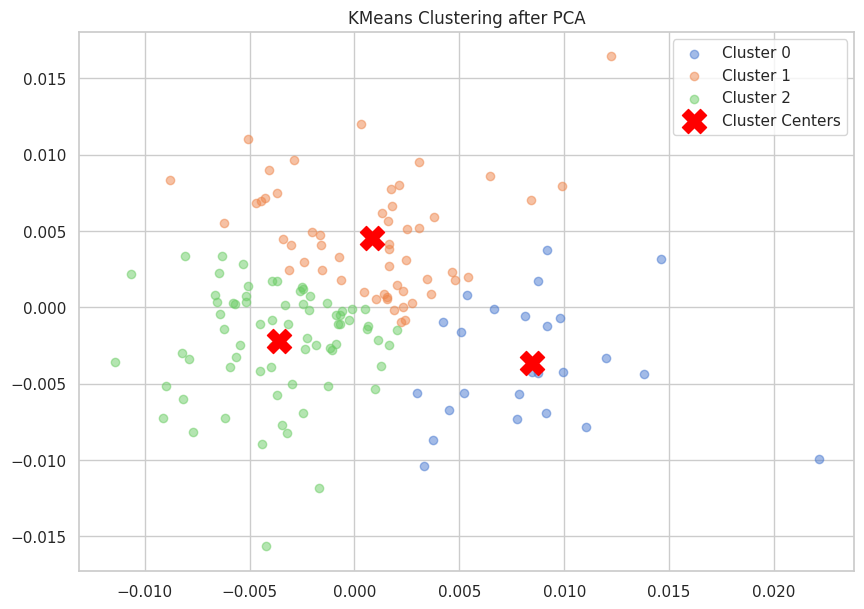

In [64]:
plt.figure(figsize=(10, 7))

for i in range(3): # [0, 1, 2] for [negative, neutral, positive]
    plt.scatter(pca_result[clustered_labels == i][:, 0], 
                pca_result[clustered_labels == i][:, 1], 
                label=f"Cluster {i}", alpha=0.5)
    
# Plotting cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], 
            kmeans.cluster_centers_[:, 1], 
            s=300, c='red', marker='X', label="Cluster Centers")

plt.legend()
plt.title('KMeans Clustering after PCA')
plt.show()

#### Batch Normalization in the GRU model serves to:

+ `Normalize Activations`: It ensures the outputs from the dense layer have a mean close to 0 and a standard deviation close to 1.

+ `Stabilize Training`: It stabilizes the gradient flow through the network, allowing for a smoother and faster training process.

+ `Allow Higher Learning Rates`: Due to the increased stability, the model can use higher learning rates, which can lead to quicker convergence.

+ `Regularization`: It adds slight noise to the activations, similar to Dropout, helping to prevent overfitting.

### Model 2: GRU

***Input (text) -> Tokenize -> Embedding -> Layers (GRU) -> Output (label probability)***


In [65]:
def create_gru_model(learning_rate=0.01, dense_units=64, dropout=0.5, l2_reg=0.01, activation='relu', kernel_size=2, padding='valid', kernel_initializer="he_uniform", batch_normalization=True):
    inputs = layers.Input(shape=(1,), dtype="string")

    x = text_vectorizer(inputs)
    x = create_embedding_layer(name='gru_embedding')(x)

    x = layers.GRU(dense_units, return_sequences=True, dropout=dropout)(x)
    x = layers.Conv1D(64, kernel_size=kernel_size, padding=padding, kernel_initializer=kernel_initializer)(x)
    x = layers.GlobalAveragePooling1D()(x)  # helps in reducing overfitting
    
    # Regularized dense layer
    x = layers.Dense(dense_units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    if batch_normalization:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)  # Dropout

    outputs = layers.Dense(3, activation="softmax")(x)
    model = Model(inputs, outputs, name="gru_model")
    
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])
    
    return model

In [66]:
gru_model = perform_random_search(create_gru_model, model_name='GRU')


GRU Model Results After Hyperparameter Tuning:

Params: {'padding': 'same', 'learning_rate': 0.001, 'l2_reg': 0.1, 'kernel_initializer': 'he_normal', 'epochs': 5, 'dropout': 0.2, 'dense_units': 64, 'batch_size': 16, 'batch_normalization': False} - Mean Test Score: 0.93 - Rank: 1
Params: {'padding': 'valid', 'learning_rate': 0.01, 'l2_reg': 0.1, 'kernel_initializer': 'he_uniform', 'epochs': 5, 'dropout': 0.4, 'dense_units': 64, 'batch_size': 16, 'batch_normalization': False} - Mean Test Score: 0.90 - Rank: 3
Params: {'padding': 'same', 'learning_rate': 0.01, 'l2_reg': 0.001, 'kernel_initializer': 'he_uniform', 'epochs': 3, 'dropout': 0.3, 'dense_units': 64, 'batch_size': 16, 'batch_normalization': True} - Mean Test Score: 0.91 - Rank: 2

Best Parameters from GRU model: {'padding': 'same', 'learning_rate': 0.001, 'l2_reg': 0.1, 'kernel_initializer': 'he_normal', 'epochs': 5, 'dropout': 0.2, 'dense_units': 64, 'batch_size': 16, 'batch_normalization': False}



In [67]:
gru_model_results = display_dl_results(gru_model, model_name='GRU')

Model: "gru_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 gru_embedding (Embedding)   (None, 24, 128)           2560000   
                                                                 
 gru_15 (GRU)                (None, 24, 64)            37248     
                                                                 
 conv1d_15 (Conv1D)          (None, 24, 64)            8256      
                                                                 
 global_average_pooling1d_15  (None, 64)               0         
  (GlobalAveragePooling1D)                               

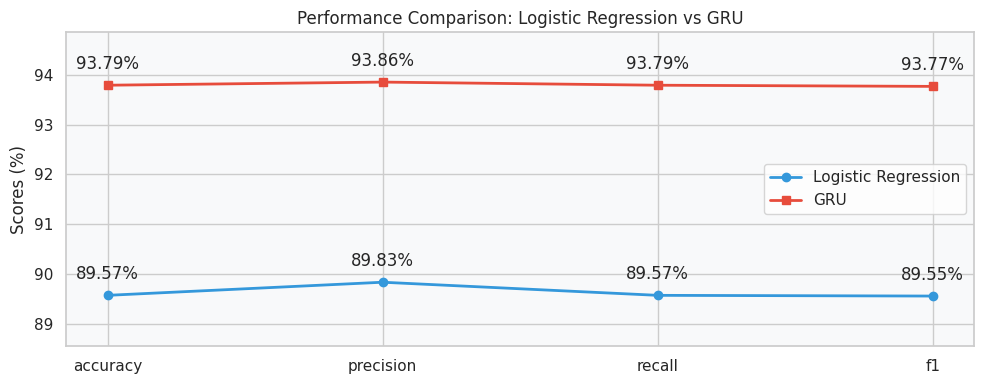

In [68]:
# Compare Model 2: GRU with Model 0: Logistic Regression model
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=gru_model_results,
                                baseline_name='Logistic Regression', new_model_name='GRU')

### Model 3: Bidirectional RNN

***Input (text) -> Tokenize -> Embedding -> Bidirectional(Layers) -> Output (label probability)***

In [69]:
def create_bidirectional_lstm_model(learning_rate=0.01, dense_units=64, dropout=0.5, l2_reg=0.01, activation='relu', batch_normalization=True):
    inputs = layers.Input(shape=(1,), dtype="string")

    x = text_vectorizer(inputs)
    x = create_embedding_layer(name='bidirectional_lstm_embedding')(x)

    # Bidirectional LSTM with dropout
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=dropout))(x)
    x = layers.Bidirectional(layers.LSTM(dense_units, dropout=dropout))(x) 

    # Regularized dense layer
    x = layers.Dense(dense_units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x) 
    if batch_normalization:
        x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(3, activation="softmax")(x)
    model = Model(inputs, outputs, name="bidirectional_lstm_model")
    
    model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=["accuracy"])
    
    return model

In [70]:
bidirectional_lstm_model = perform_random_search(create_bidirectional_lstm_model, model_name='Bidirectional LSTM')


Bidirectional LSTM Model Results After Hyperparameter Tuning:

Params: {'learning_rate': 0.0001, 'l2_reg': 0.01, 'epochs': 3, 'dropout': 0.2, 'dense_units': 128, 'batch_size': 32, 'batch_normalization': True} - Mean Test Score: 0.88 - Rank: 2
Params: {'learning_rate': 0.01, 'l2_reg': 0.1, 'epochs': 3, 'dropout': 0.2, 'dense_units': 128, 'batch_size': 32, 'batch_normalization': True} - Mean Test Score: 0.76 - Rank: 3
Params: {'learning_rate': 0.001, 'l2_reg': 0.01, 'epochs': 3, 'dropout': 0.2, 'dense_units': 64, 'batch_size': 16, 'batch_normalization': False} - Mean Test Score: 0.92 - Rank: 1

Best Parameters from Bidirectional LSTM model: {'learning_rate': 0.001, 'l2_reg': 0.01, 'epochs': 3, 'dropout': 0.2, 'dense_units': 64, 'batch_size': 16, 'batch_normalization': False}



In [71]:
bidirectional_lstm_model_results = display_dl_results(bidirectional_lstm_model, model_name='Bidirectional LSTM')

Model: "bidirectional_lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 24)               0         
 torization)                                                     
                                                                 
 bidirectional_lstm_embeddin  (None, 24, 128)          2560000   
 g (Embedding)                                                   
                                                                 
 bidirectional_30 (Bidirecti  (None, 24, 256)          263168    
 onal)                                                           
                                                                 
 bidirectional_31 (Bidirecti  (None, 128)              164352    
 onal)                                    

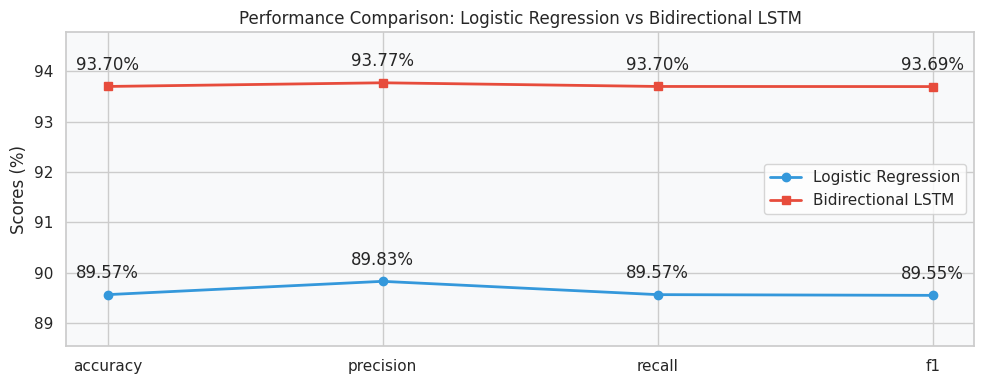

In [72]:
# Compare Model 3: Bidirectional RNN with Model 0: Logistic Regression model
compare_baseline_to_new_results(baseline_results=lr_results,
                                new_model_results=bidirectional_lstm_model_results,
                                baseline_name='Logistic Regression', new_model_name='Bidirectional LSTM')

## Compare Models

| Term      | Description | Formula |
|-----------|-------------|---------|
| Accuracy  | Accuracy is the ratio of the correctly predicted instances to the total instances in the dataset. It gives an overall performance measure of the model. | `(True Positives + True Negatives) / (Total Instances)` |
| Precision | Precision (also known as Positive Predictive Value) is the fraction of relevant instances among the retrieved instances. | `True Positives / (True Positives + False Positives)` |
| Recall    | Recall (also known as Sensitivity or True Positive Rate) measures the number of true positive predictions among the actual positive instances in the dataset. | `True Positives / (True Positives + False Negatives)` |
| F1-Score  | The F1-Score is the harmonic mean of precision and recall. | `2 * (Precision * Recall) / (Precision + Recall)` |

In [73]:
all_model_results = pd.DataFrame({'logistic_regression': lr_results,
                                  "svm": svm_results,
                                  'random_forest': rf_results,
                                  'ml_ensemble': ml_ensemble_results,
                                  "fully_connected_layers": fc_model_results,
                                  "gru": gru_model_results,
                                  "bidirectional": bidirectional_lstm_model_results
                                 })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
logistic_regression,89.569155,0.898327,0.895692,0.895549
svm,90.243542,0.904318,0.902435,0.902015
random_forest,93.654190,0.936736,0.936542,0.936047
ml_ensemble,90.224151,0.903343,0.902242,0.902075
fully_connected_layers,93.307468,0.933922,0.933075,0.932752
gru,93.792435,0.938554,0.937924,0.937690
bidirectional,93.695441,0.937682,0.936954,0.936932


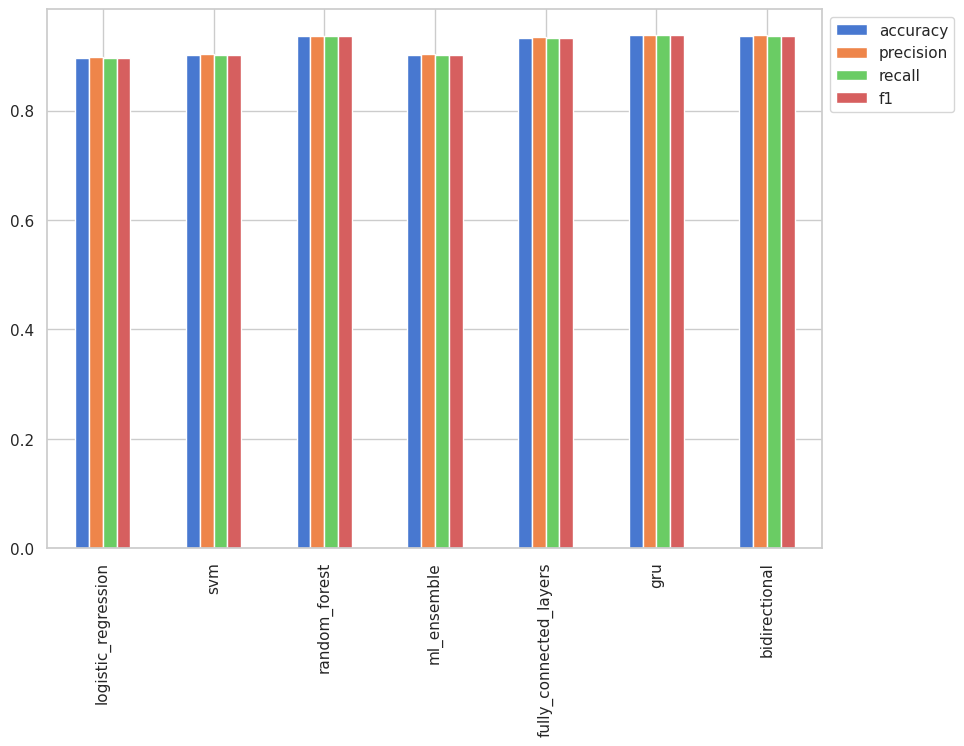

In [74]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

## Model Evaluation

In [75]:
# Reverse mapping
reverse_label_map = {
    0: "negative",
    1: "neutral",
    2: "positive"
}

# Convert sentences to a list if they're in a Pandas Series
if isinstance(test_sentences, pd.Series):
    test_sentences = test_sentences.tolist()

In [76]:
ML_MODELS = {
    'SVM': svm_model,
    'Random Forest': rf_model,
    'Logistic Regression': lr_model,
    'Stacked ML Models': ml_ensemble_model
}

DL_MODELS = {
    "Fully Connected Layers": fc_model,
    "GRU": gru_model,
    "Bidirectional LSTM": bidirectional_lstm_model
}

# Define which models are deep learning models
is_deep_learning_dict = {
    'SVM': False,
    'Random Forest': False,
    'Logistic Regression': False,
    'Stacked ML Models': False,
    "Fully Connected Layers": True,
    "GRU": True,
    "Bidirectional LSTM": True
}

ALL_MODELS = {**ML_MODELS, **DL_MODELS}

print("Names of all available models:")
for model_type, models_dict in [('Machine Learning', ML_MODELS), ('Deep Learning', DL_MODELS)]:
    print(f"\n{model_type} Models:")
    for model_name in models_dict.keys():
        print(f"- {model_name}")

Names of all available models:

Machine Learning Models:
- SVM
- Random Forest
- Logistic Regression
- Stacked ML Models

Deep Learning Models:
- Fully Connected Layers
- GRU
- Bidirectional LSTM


In [77]:
def predict_on_multiple_sentences(model_name, sentences=test_sentences, actual_labels=test_labels.tolist(), is_deep_learning_dict=is_deep_learning_dict, vectorizer=vectorizer, label_map=reverse_label_map, ALL_MODELS=ALL_MODELS, n=10):
    # Select n random sentences and corresponding labels
    n = min(n, len(sentences)) # ensure that n does not exceed the number of available sentences
    random_indices = random.sample(range(len(sentences)), n)
    random_sentences = [sentences[i] for i in random_indices]
    random_actual_labels = [actual_labels[i] for i in random_indices]

    model = ALL_MODELS[model_name]
    is_deep_learning = is_deep_learning_dict[model_name]
    
    # Print random n sentences
    for i, sentence in enumerate(random_sentences):
        if is_deep_learning:
            pred_probs = model.predict([sentence], verbose=0)
            pred_labels = tf.argmax(pred_probs, axis=1).numpy()
            pred_prob = np.max(pred_probs, axis=1)[0]  # get the highest probability as the predicted probability

        else:
            test_features = vectorizer.transform([sentence])
            pred_labels = model.predict(test_features)

        # 0, 1, 2 --> negative, neutral, positive
        mapped_pred_label = label_map[pred_labels[0]]
        mapped_actual_label = label_map[random_actual_labels[i]]

        print(f"\nText: {sentence}\n")
        if is_deep_learning:
            print(f"Prediction: {mapped_pred_label}", f", Probability: {pred_prob * 100:.2f}%", f", Actual: {mapped_actual_label}\n")
        else:
            print(f"Prediction: {mapped_pred_label}", f", Actual: {mapped_actual_label}\n")

predict_on_multiple_sentences(model_name='Bidirectional LSTM', n=10)


Text: giảng_dạy nhiệt_tình hiệu_quả tốt

Prediction: positive , Probability: 99.91% , Actual: positive


Text: giảng_viên dạy dễ hiểu bài_tập hay tận_tình

Prediction: positive , Probability: 99.90% , Actual: positive


Text: thầy diễn_đạt khó hiểu giọng nói khó nghe

Prediction: negative , Probability: 98.81% , Actual: negative


Text: ví_dụ như mục quy_hoạch_động là mục em thích_thú nhưng cô nói đây là mục khó cô dạy chỉ những ví_dụ cực_kỳ cơ_bản

Prediction: negative , Probability: 96.40% , Actual: negative


Text: cần thêm nhiều tài_liệu cho sinh_viên

Prediction: negative , Probability: 98.42% , Actual: negative


Text: chi_tiết dễ hiểu

Prediction: positive , Probability: 99.76% , Actual: positive


Text: thầy giảng bài tận_tâm và rất nhiệt_tình

Prediction: positive , Probability: 99.88% , Actual: positive


Text: cô giảng_dạy tận_tình nhiệt_huyết

Prediction: positive , Probability: 99.92% , Actual: positive


Text: thân_thiện nhiệt_tình

Prediction: positive , Probability: 99

In [78]:
# Deep Learning Models only
def check_most_wrong(model, sentences, actual_labels, reverse_label_map, n=10): 
    wrong_predictions = []

    for i, sentence in enumerate(sentences):
        pred_probs = model.predict([sentence], verbose=0)
        pred_label = tf.argmax(pred_probs, axis=1).numpy()
        actual_label_idx = actual_labels[i]

        # Calculate the probability difference between the predicted and actual labels
        prob_diff = abs(pred_probs[0][actual_label_idx] - np.max(pred_probs, axis=1))

        # Map the predicted and actual labels back from integer to string label
        mapped_pred_label = reverse_label_map[pred_label[0]]
        mapped_actual_label = reverse_label_map[actual_label_idx]

        wrong_predictions.append({
            "sentence": sentence,
            "predicted_label": mapped_pred_label,
            "actual_label": mapped_actual_label,
            "probability_diff": prob_diff[0]
        })

    # Sort the predictions by the most wrong
    most_wrong_predictions = sorted(wrong_predictions, key=lambda x: x["probability_diff"], reverse=True)

    # Display the n most wrong predictions
    for prediction in most_wrong_predictions[:n]:
        print(f"\nText: {prediction['sentence']}\n")
        print(f"Prediction: {prediction['predicted_label']}",
              f", Probability Difference: {prediction['probability_diff'] * 100:.2f}%",
              f", Actual: {prediction['actual_label']}\n")

# Usage example
actual_labels = test_labels.tolist() 
actual_test_sentences = test_sentences
check_most_wrong(bidirectional_lstm_model, actual_test_sentences, actual_labels, reverse_label_map, n=10)


Text: cô dạy rất nhiệt_tình tận_tâm và chu_đáo

Prediction: positive , Probability Difference: 99.87% , Actual: negative


Text: thầy cung_cấp nhiều thông_tin hay hữu_ích đối_với đồ_án

Prediction: positive , Probability Difference: 99.80% , Actual: negative


Text: thầy khá là tận_tâm trong việc truyền_đạt kiến_thức

Prediction: positive , Probability Difference: 99.50% , Actual: negative


Text: nhắc_nhở sinh_viên là ý tốt của thầy nhưng thật_sự tụi em thấy rất áp_lực với môn_học này

Prediction: positive , Probability Difference: 99.10% , Actual: negative


Text: ấn_tượng nhất doubledot dạy không cần máy_chiếu hay laptop nhưng lượng bài giảng có_thể nói là khủng_nhìn thầy ghi bài giảng lên bảng mà bất_ngờ

Prediction: negative , Probability Difference: 99.01% , Actual: positive


Text: thầy dạy hay kêu sinh_viên uống bia

Prediction: positive , Probability Difference: 98.82% , Actual: negative


Text: chuẩn_bị đầy_đủ các phần_mềm chương_trình cần_thiết sẵn trong các phòng thực_hành

In [79]:
def evaluate_model_on_test_data(model, test_sentences, test_labels, vectorizer, is_deep_learning=False):
    '''
    Accept both ML and DL models
    
    Evaluate selected model on test data
    '''
    if is_deep_learning:
        pred_probs = model.predict(test_sentences)
        pred_labels = tf.argmax(pred_probs, axis=1).numpy()
        
    else:
        test_features = vectorizer.transform(test_sentences) # transform test sentences into numerical feature vectors
        pred_labels = model.predict(test_features)
    
    # Calculate evaluation metrics
    results = calculate_results(test_labels, pred_labels)
    
    return pred_labels, results

In [80]:
def get_models_performance(models_dict, test_sentences, test_labels, vectorizer, is_deep_learning_dict):
    """
    Evaluate all models in a dictionary and return their performance.
    """
    performance = {}
    for model_name, model in models_dict.items():
        is_deep_learning = is_deep_learning_dict[model_name]
        _, results = evaluate_model_on_test_data(model, test_sentences, test_labels, vectorizer, is_deep_learning)
        performance[model_name] = results
    return performance

def select_best_model_from_dict(models_performance, metric='accuracy'):
    """
    Selects the best model from the dictionary based on the given metric.
    """
    best_model_name = max(models_performance, key=lambda x: models_performance[x][metric])
    best_score = models_performance[best_model_name][metric]
    return best_model_name, best_score

In [81]:
model_name = "Fully Connected Layers"
test_results_dl = evaluate_model_on_test_data(ALL_MODELS[model_name], test_sentences, test_labels, vectorizer, is_deep_learning=is_deep_learning_dict[model_name])
test_results_dl

51/51 [==============================] - 0s 2ms/step


(array([2, 2, 1, ..., 2, 2, 0]),
 {'accuracy': 88.0716934487021,
  'precision': 0.887043289519213,
  'recall': 0.880716934487021,
  'f1': 0.8835669728171953})

In [82]:
# Get model performances
ml_models_performance = get_models_performance(ML_MODELS, test_sentences, test_labels, vectorizer, is_deep_learning_dict)
dl_models_performance = get_models_performance(DL_MODELS, test_sentences, test_labels, vectorizer, is_deep_learning_dict)

# Find the best models based on a metric, e.g., 'f1'
best_ml_model_name, best_ml_model_score = select_best_model_from_dict(ml_models_performance, metric='accuracy')
best_dl_model_name, best_dl_model_score = select_best_model_from_dict(dl_models_performance, metric='accuracy')

print(f"The best ML model is {best_ml_model_name} with an F1 score of {best_ml_model_score:.2f}.")
print(f"The best DL model is {best_dl_model_name} with an F1 score of {best_dl_model_score:.2f}.")

51/51 [==============================] - 1s 27ms/step
The best ML model is Random Forest with an F1 score of 88.38.
The best DL model is GRU with an F1 score of 89.12.


https://dl.acm.org/doi/pdf/10.1145/3589131